## Name         :- Darpan Gaur
## Roll Number  :- CO21BTECH11004

In [11]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.manifold import TSNE
import random

In [12]:
# set seed
seed = 32
np.random.seed(seed)
random.seed(seed)

In [13]:
# function from pervious assignment
def get_normalized_histogram(img):
    # custum histogram function
    hist = np.zeros(256)
    for i in img.flatten():
        hist[i] += 1
    hist = hist / np.sum(hist)
    return hist

def entropy(pmf):
    # convert to numpy array and remove zeros
    pmf = np.array(pmf)
    # remove zeros and ones
    pmf = pmf[(pmf != 0.0) & (pmf != 1.0)]
    entropy = 0
    for p in pmf:
        entropy += -p * np.log2(p)
    return entropy

def KL_divergence(p, q):
    p = np.array(p)
    q = np.array(q)
    # remove zeros
    p1 = p[(p != 0) | (q != 0)]
    q1 = q[(p != 0) | (q != 0)]
    return np.sum(p1 * np.log2(p1/q1))

def KL_divergence2(p, q):
    p = np.array(p)
    q = np.array(q)
    # remove zeros
    tol = 1e-12
    p1 = p[(abs(p) > tol) & (abs(q) > tol)]
    q1 = q[(abs(p) > tol) & (abs(q) > tol)]
    return np.sum(p1 * np.log2(p1/q1))

## Que 1 (a) i

In [14]:
# read image
left = cv2.imread('left.png', -1)
right = cv2.imread('right.png', -1)

def get_cross_entropy(p, q):
    ce = 0
    for pi, qi in zip(p, q):
        if pi == 0 or qi == 0:
            continue
        ce += pi * np.log2(qi)
    return -ce
    # return  KL_divergence(p, q)
hist_left = get_normalized_histogram(left)
hist_right = get_normalized_histogram(right)

ce = get_cross_entropy(hist_left, hist_right)
print('cross entropy:', ce)


cross entropy: 7.273398119987329


## # Que 1 (a) ii

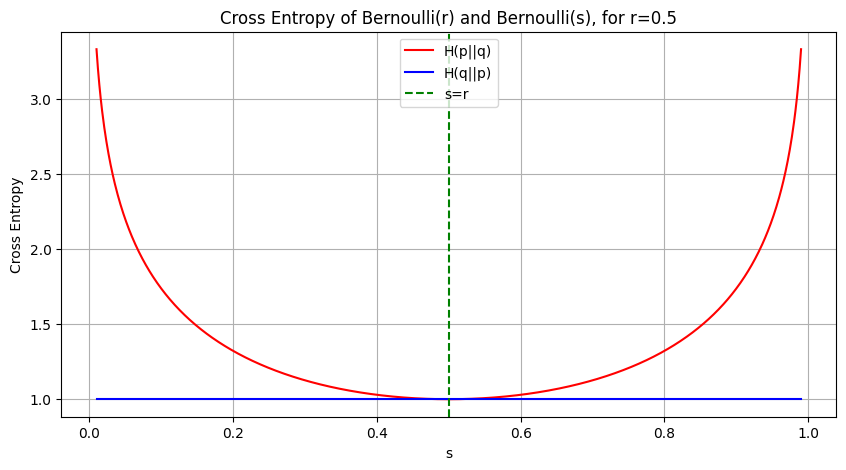

In [15]:

r = 0.5
s = np.linspace(0.01, 0.99, 1000)
p = [r, 1-r]
Hpq = np.array([get_cross_entropy(p, [i, 1-i]) for i in s])
Hqp = np.array([get_cross_entropy([i, 1-i], p) for i in s])

plt.figure(figsize=(10, 5))
plt.plot(s, Hpq, color='r', label='H(p||q)')
plt.plot(s, Hqp, color='b', label='H(q||p)')
plt.xlabel("s")
plt.ylabel("Cross Entropy")
plt.title("Cross Entropy of Bernoulli(r) and Bernoulli(s), for r=0.5")
plt.axvline(x=r, linestyle='--', color='g', label='s=r')
plt.legend()
plt.grid()
plt.show()


Yes, by plot we can see that by minimizing H(p, q), gives us matched pmfs.

## Que 1 (b)

In [16]:

def get_jensenShannon_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * get_cross_entropy(p, m) + 0.5 * get_cross_entropy(q, m)

js = get_jensenShannon_divergence(hist_left, hist_right)
print('Jensen Shannon Divergence (left, right):', js)

# verify that jensen shannon divergence is symmetric
js1 = get_jensenShannon_divergence(hist_right, hist_left)
print('Jensen Shannon Divergence (right, left):', js1)

# print KL divergence
kl = KL_divergence(hist_left, hist_right)
print('KL divergence: (left, right)', kl)

# print KL divergence
kl1 = KL_divergence(hist_right, hist_left)
print('KL divergence: (right, left)', kl1)


Jensen Shannon Divergence (left, right): 7.2721328579923465
Jensen Shannon Divergence (right, left): 7.2721328579923465
KL divergence: (left, right) 0.015104015237387056
KL divergence: (right, left) 0.014409785833354479


- As JS(left||right) = JS(right||left), so the Jensen-Shannon divergence is symmetric.
- Since D_KL(left||right) != D_KL(right||left), the Kullback-Leibler divergence is not symmetric.

## Que 1 (c)

In [17]:

def check_p_in_Pi(p, r, s):
    # check if marginals are equal
    rX = np.sum(p, axis=1)
    sY = np.sum(p, axis=0)
    if np.allclose(rX, r) and np.allclose(sY, s):
        return True
    return False

# Example 1 -> positive case
p_xy = np.array([[0.1, 0.2], [0.2, 0.5]])
r = np.array([0.3, 0.7])
s = np.array([0.3, 0.7])
print('Example 1:', check_p_in_Pi(p_xy, r, s))

# Example 2 -> negative case
p_xy = np.array([[0.1, 0.2], [0.2, 0.5]])
r = np.array([0.3, 0.7])
s = np.array([0.2, 0.8])
print('Example 2:', check_p_in_Pi(p_xy, r, s))



Example 1: True
Example 2: False


### Que 2 (a) i
Crowding Problem: When we go from high dimension to low dimenisons, there is not enough space to represent data points and maintain their relative distances. This is called crowding problem. Data points in lower dimensions can't model distances between data points as they were in higher dimensions. 

### Que 2 (a) ii
- In t-SNE we use Student-t distribution as the heavy-tailed model in low dimensional space.
- This makes the representation of joint probabilities resistant to changes in the scale of the map for points that are far apart, allowing them to interact similarly to individual points.
- This allows moderate distances in high dimensions to be mapped as larger distances in lower dimenisons, reducing unwanted attraction between dissimilar points.

### Que 2 (a) iii
Important changes made in t-SNE relative to SNE are as follows:
1. t-SNE uses a symmetrized version of the SNE cost function with simpler gradients.
    - The cost function used in SNE is not symmetric, which makes it difficult to optimize. t-SNE uses a symmetrized version of the SNE cost function with simpler gradients.
    - For outliers, $ p_{ij} $ values are very small, so the map point $ y_i $ has little impact on the cost function and is poorly determined. We fix this by defining $ p_{ij} = \frac{p_{j|i} + p_{i|j}}{2n} $, ensuring $ \sum_j p_{ij} > \frac{1}{2n} $, so each point significantly contributes.
2. Student t-distribution is used to measure similarity between low dimensional data points.
    - Heps in reducing crowding problem.
    - It makes representation of joint probabilities robust to change in scale of map of points that are far apart, so they interact in same way as they are indvidual points.

## Que 2 (b)

In [55]:

'''
Generate two clusters of points from a ten-dimensional multivariate Gaussian (MVG) distri-
bution N (μ, 0.01 · I) where I is the ten-dimensional identity matrix.
'''

def generate_clusters(n, d, mu, sigma):
    # generate n points from a d-dimensional multivariate Gaussian distribution
    cov = sigma * np.eye(d)
    return np.random.multivariate_normal(mu, cov, n)

'''
Use μ1 = 1 for one cluster and μ2 = 10 · 1 for the other (where 1 is the ten-dimensional
vector of ones).
'''
n = 10
d = 10
mu1 = np.ones(d)
mu2 = 10 * mu1
sigma = 0.01

# cluster1 = generate_clusters(n, d, mu1, sigma)
# cluster2 = generate_clusters(n, d, mu2, sigma)
cluster1 = np.random.multivariate_normal(mu1, sigma * np.eye(d), n)
cluster2 = np.random.multivariate_normal(mu2, sigma * np.eye(d), n)


Initial D(x||y): 1.0977417647457524
Final D(x||y): 0.31587687011945303


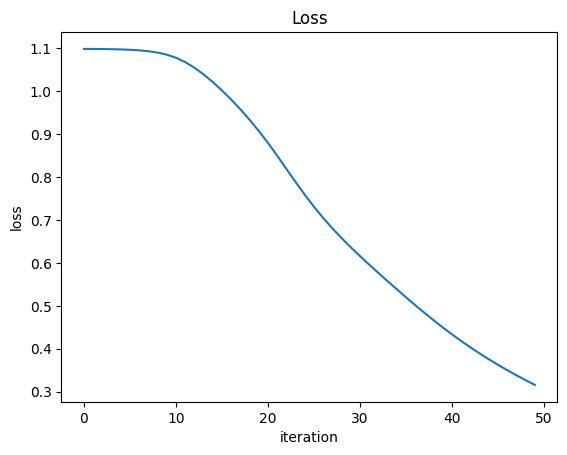

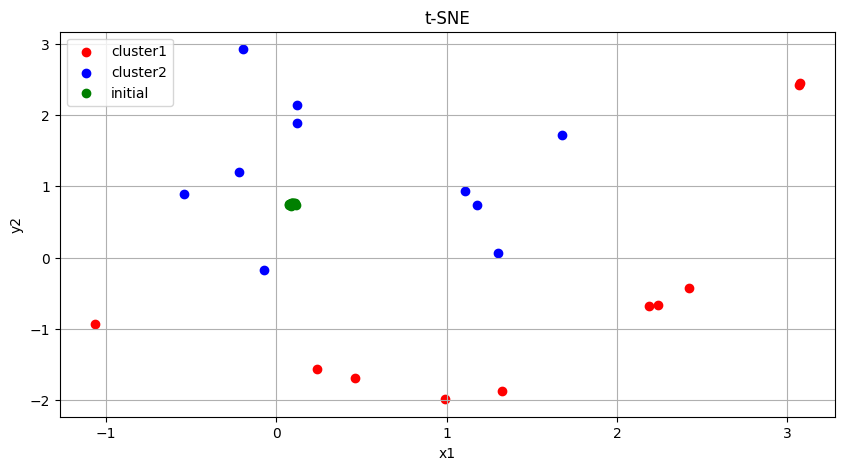

In [62]:
# t-sne implementation

# get ||x_i - x_j||^2 
def get_pairwise_distance(X):
    # get pairwise distance
    n = X.shape[0]
    distance = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            distance[i, j] = np.sum((X[i] - X[j])**2)
    distance = distance + distance.T
    return distance

# get p_ij
def get_pij(X_D, sigma):
    n = X_D.shape[0]
    pij = np.zeros((n, n))
    for i in range(n):
        pij[i, :] = np.exp(-X_D[i, :] / (2 * sigma**2))
        pij[i, i] = 0
        pij[i, :] = pij[i, :] / np.sum(pij[i, :])
    return (pij + pij.T) / (2 * n)

# get q_ij
def get_qij(y):
    n = y.shape[0]
    qij = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            qij[i, j] = 1 / (1 + np.sum((y[i] - y[j])**2))
        qij[i, i] = 0
    qij = qij / np.sum(qij)
    return qij

# get gradient
def get_gradient(pij, qij, y):
    n = y.shape[0]
    d = y.shape[1]
    grad = np.zeros((n, d))
    for i in range(n):
        for j in range(n):
            grad[i] += 4 * (pij[i, j] - qij[i, j]) * (y[i] - y[j]) / (1+np.sum((y[i] - y[j])**2))
    return grad
    

def tsne(X, d, std, niter=50, eta=0.45, alpha=0.30):
    # get pairwise distance
    X_D = get_pairwise_distance(X)
    # get p_ij
    pij = get_pij(X_D, std)

    # initialize Y
    # Y = generate_clusters(X.shape[0], d, np.random.rand(d), 1e-4)
    Y = np.random.multivariate_normal(np.random.rand(d), 1e-4 * np.eye(d), X.shape[0])
    Y_init = Y.copy()

    y_t2 = np.zeros(Y.shape)
    y_t1 = Y.copy()
    # loss plot
    loss = []
    for _ in range(niter):
        # get q_ij
        qij = get_qij(Y)
        # get gradient
        grad = get_gradient(pij, qij, Y)
        # update Y
        Y = y_t1 - eta * grad + alpha * (y_t1 - y_t2)
        y_t2 = y_t1
        y_t1 = Y
        # loss
        loss.append(KL_divergence2(pij, qij))
    
    return Y, Y_init, loss

# t-sne
X = np.concatenate((cluster1, cluster2), axis=0)
Y, Y_init, loss = tsne(X, 2, 0.1, niter=50, eta=0.6, alpha=0.5)

# print initial and final loss
print('Initial D(x||y):', loss[0])
print('Final D(x||y):', loss[-1])

# plot loss
plt.plot(loss)
plt.title('Loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()


# plot Y
plt.figure(figsize=(10, 5))
plt.scatter(Y[:n, 0], Y[:n, 1], color='r', label='cluster1')
plt.scatter(Y[n:, 0], Y[n:, 1], color='b', label='cluster2')
plt.scatter(Y_init[:, 0], Y_init[:, 1], color='g', label='initial')
plt.xlabel("x1")
plt.ylabel("y2")
plt.title("t-SNE")  
plt.legend()
plt.grid()
plt.show()


In [ ]:
# make array 0.1 to 1 having 10 elements
s = np.linspace(0.1, 1, 10)
print(s)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [51]:
# print KL divergence of p_ij and q_ij for the last iteration FOR DIFFERNET values of eta and alpha
# plot them in a 2D grid
etas = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
alphas = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

kl_div = np.zeros((10, 10))
for i, eta in enumerate(etas):
    for j, alpha in enumerate(alphas):
        Y, Y_init, _ = tsne(X, 2, 0.1, niter=50, eta=eta, alpha=alpha)
        
        kl_div[i, j] = KL_divergence2(get_pij(get_pairwise_distance(X), 0.1), get_qij(Y))
        print('eta:', eta, 'alpha:', alpha, 'KL divergence:', kl_div[i, j])

plt.figure(figsize=(10, 5))
plt.imshow(kl_div, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.xlabel("alpha")
plt.ylabel("eta")
plt.title("KL Divergence")
plt.xticks(range(10), alphas)
plt.yticks(range(10), etas)
plt.show()


KeyboardInterrupt: 

## Que 2 (c)

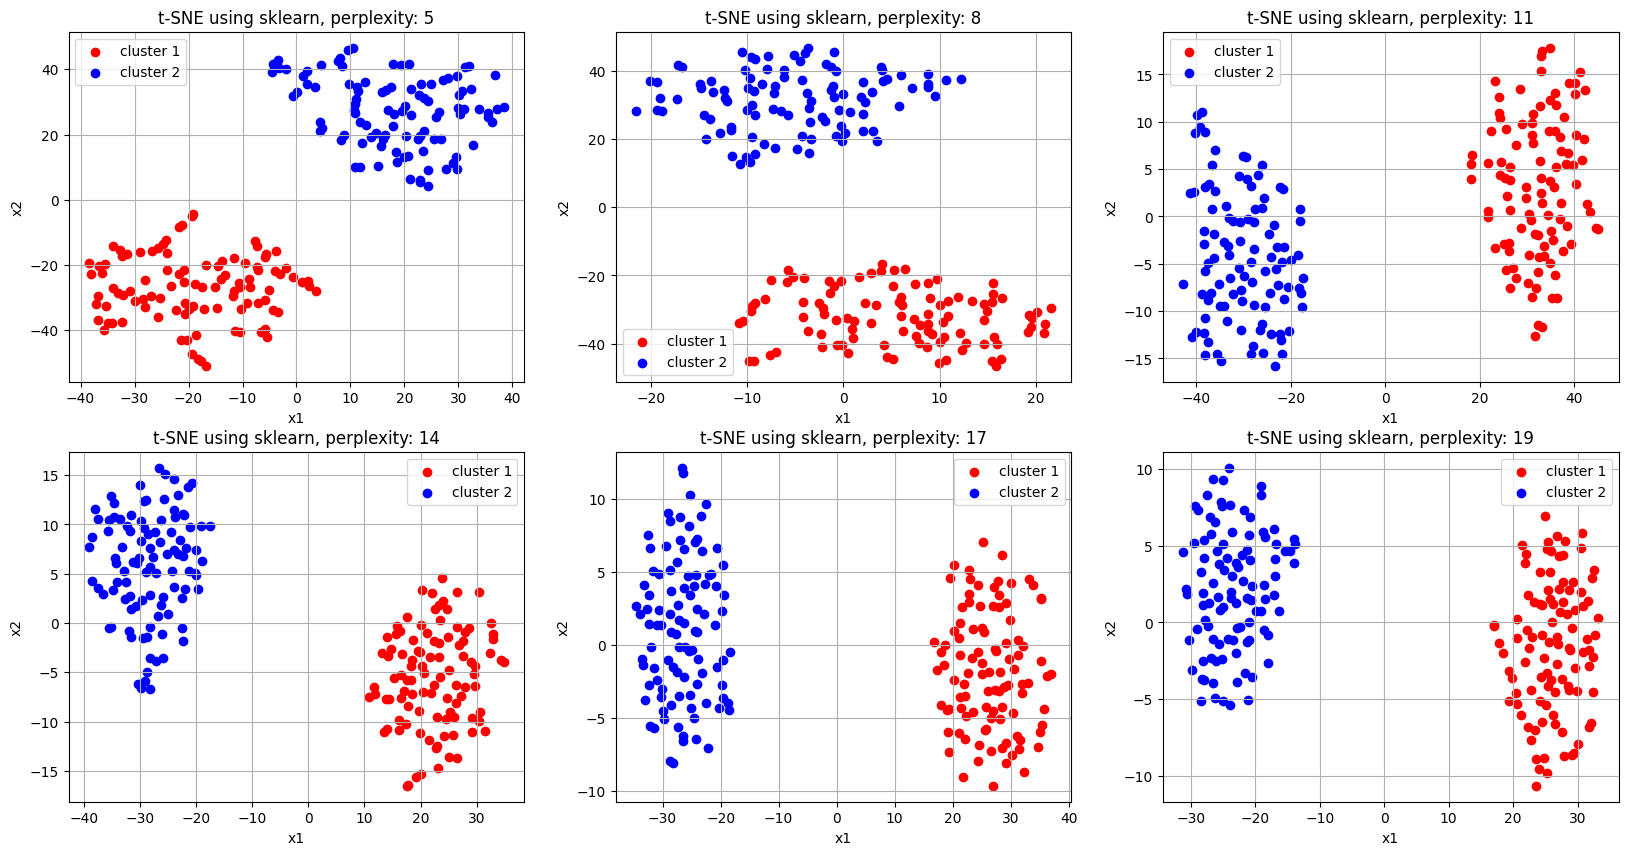

In [53]:
# 6 plots with perplexity varing from 5-19
perplexity = [5, 8, 11, 14, 17, 19]
plt.figure(figsize=(20, 10))
for i, p in enumerate(perplexity):
    X_embedded = TSNE(n_components=2, perplexity=p).fit_transform(X)
    plt.subplot(2, 3, i+1)
    plt.scatter(X_embedded[:n, 0], X_embedded[:n, 1], color='r', label='cluster 1')
    plt.scatter(X_embedded[n:, 0], X_embedded[n:, 1], color='b', label='cluster 2')
    plt.title('t-SNE using sklearn, perplexity: {}'.format(p))
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.grid()
plt.show()

- Perplexity is a hyperparameter in t-SNE that balances the local and global aspects of the data. 
- Lower perplexity emphasizes local structure, leading to more compact clusters. [Eg perplexity = 5, 8]
- Higher perplexity emphasizes global structure, leading to more spread out clusters. [Eg perplexity = 17, 19]